In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
geemap.set_proxy(port=10809)
# ee.Authenticate()
ee.Initialize()

# 获取每个数据集的最新影像及其日期
def get_latest_date(image_collection, collection_name):
    latest_image = image_collection.sort("system:time_start", False).first()
    latest_date = ee.Date(latest_image.get("system:time_start")).format("YYYY-MM-dd")
    return f"{collection_name} 最新日期: {latest_date.getInfo()}"

In [2]:
SETP_region = ee.FeatureCollection('projects/ee-mrwurenzhe/assets/ChinaShp/SouthestRegion').first().geometry()
START_DATE = '2015-01'; END_DATE   = '2024-12'

GLDAS2_2 = ee.ImageCollection("NASA/GLDAS/V022/CLSM/G025/DA1D").filterDate(START_DATE, END_DATE).filterBounds(SETP_region)
GLDAS2_1 = ee.ImageCollection("NASA/GLDAS/V021/NOAH/G025/T3H").filterDate(START_DATE, END_DATE).filterBounds(SETP_region)
ERA5_Land = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR").filterDate(START_DATE, END_DATE).filterBounds(SETP_region)

# 打印每个数据集的最新日期
print(get_latest_date(GLDAS2_2, "GLDAS2_2"))
print(get_latest_date(GLDAS2_1, "GLDAS2_1"))
print(get_latest_date(ERA5_Land, "ERA5_Land"))

GLDAS2_2 最新日期: 2024-09-30
GLDAS2_1 最新日期: 2024-11-30
ERA5_Land 最新日期: 2024-11-01


In [3]:
def calculate_monthly_avg(image, dicts={'mean_temp': 'skin_temperature'}):
    mean_temp = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=SETP_region,
        scale=1000,  # 分辨率可调整
        maxPixels=1e13
    )
    return ee.Feature(None, {
        'date': image.date().format("YYYY-MM"),
        **{key: mean_temp.get(value) for key, value in dicts.items()}
    })

# 对 ERA5 数据集应用映射以获取每个月的平均温度
ERA5_temp_C = ERA5_Land.select('skin_temperature').map(lambda img: img.subtract(273.15).set('system:time_start', img.get('system:time_start')))

monthly_avg_temp = ERA5_temp_C.map(calculate_monthly_avg)

# 将结果转换为列表并打印
temp_results = monthly_avg_temp.aggregate_array('mean_temp').getInfo()
date_results = monthly_avg_temp.aggregate_array('date').getInfo()

# 打印温度变化结果
for date, temp in zip(date_results, temp_results):
    print(f"{date}: 平均温度 = {temp:.2f} °C")

2015-01: 平均温度 = -18.27 °C
2015-02: 平均温度 = -15.73 °C
2015-03: 平均温度 = -9.09 °C
2015-04: 平均温度 = -4.39 °C
2015-05: 平均温度 = 1.64 °C
2015-06: 平均温度 = 7.95 °C
2015-07: 平均温度 = 10.34 °C
2015-08: 平均温度 = 10.40 °C
2015-09: 平均温度 = 10.01 °C
2015-10: 平均温度 = 1.59 °C
2015-11: 平均温度 = -7.43 °C
2015-12: 平均温度 = -15.53 °C
2016-01: 平均温度 = -20.29 °C
2016-02: 平均温度 = -13.21 °C
2016-03: 平均温度 = -10.82 °C
2016-04: 平均温度 = -3.74 °C
2016-05: 平均温度 = 0.36 °C
2016-06: 平均温度 = 7.05 °C
2016-07: 平均温度 = 10.75 °C
2016-08: 平均温度 = 12.53 °C
2016-09: 平均温度 = 8.07 °C
2016-10: 平均温度 = 1.11 °C
2016-11: 平均温度 = -6.17 °C
2016-12: 平均温度 = -10.84 °C
2017-01: 平均温度 = -16.89 °C
2017-02: 平均温度 = -13.41 °C
2017-03: 平均温度 = -11.46 °C
2017-04: 平均温度 = -5.21 °C
2017-05: 平均温度 = 0.77 °C
2017-06: 平均温度 = 6.62 °C
2017-07: 平均温度 = 11.13 °C
2017-08: 平均温度 = 11.80 °C
2017-09: 平均温度 = 10.02 °C
2017-10: 平均温度 = 2.92 °C
2017-11: 平均温度 = -9.42 °C
2017-12: 平均温度 = -10.24 °C
2018-01: 平均温度 = -14.95 °C
2018-02: 平均温度 = -12.20 °C
2018-03: 平均温度 = -11.54 °C
2018-04: 平均温度 = -4.94

C:\Users\A\AppData\Local\Temp\ipykernel_1780\2916220094.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


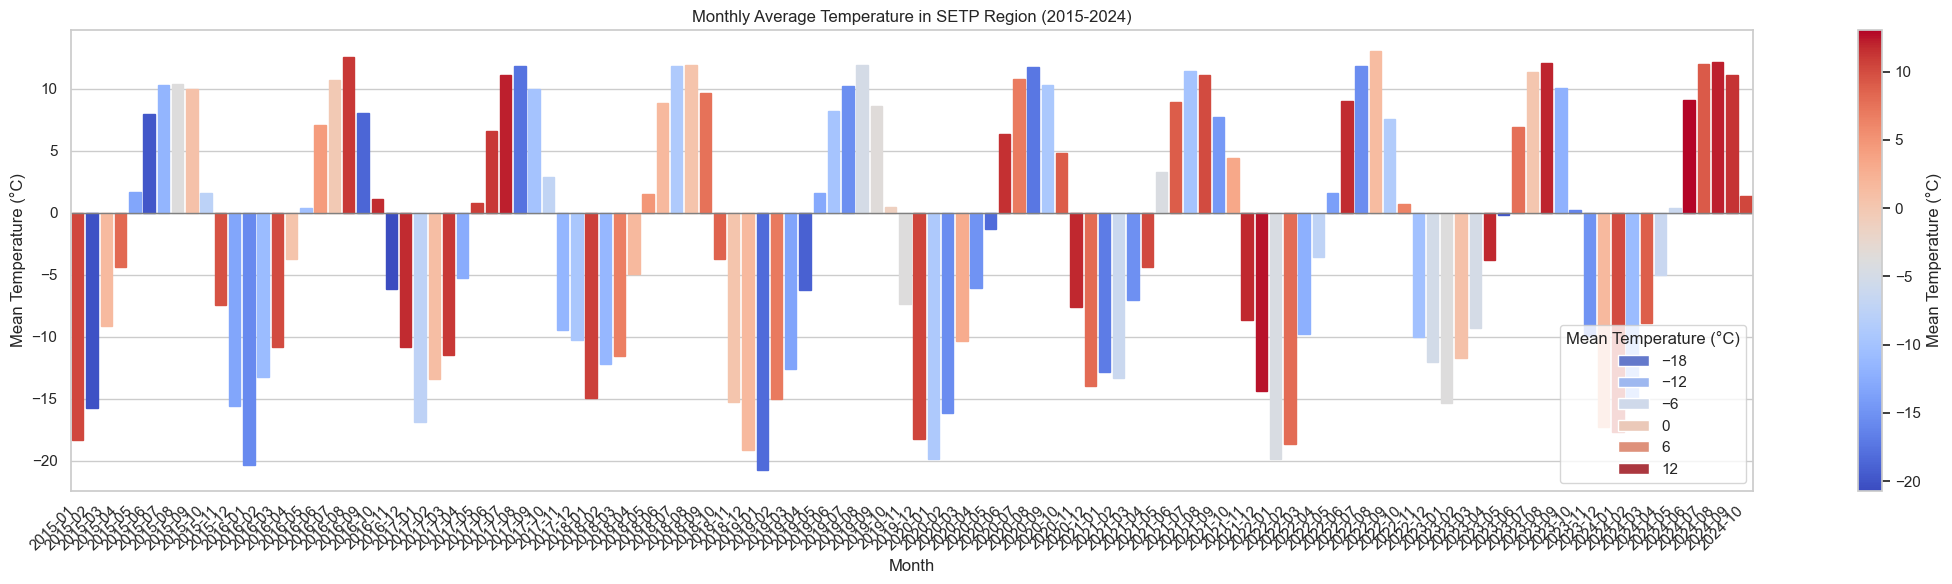

In [4]:
data = pd.DataFrame({
    'Date': date_results,
    'Mean Temperature (°C)': temp_results
})

# 设置绘图风格
sns.set(style="whitegrid")

# 定义颜色映射
norm = plt.Normalize(data['Mean Temperature (°C)'].min(), data['Mean Temperature (°C)'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

# 创建柱状图，以0为中线
plt.figure(figsize=(22, 6))
ax = sns.barplot(
    x='Date', 
    y='Mean Temperature (°C)', 
    data=data, 
    palette=sns.color_palette("coolwarm", as_cmap=True),
    hue='Mean Temperature (°C)',
    dodge=False
)

# 将条形颜色设置为基于温度的渐变色
colors = sm.to_rgba(data['Mean Temperature (°C)'])
for bar, color in zip(ax.patches, colors):
    bar.set_color(color)

# 设置 0 为中线
ax.axhline(0, color='gray', linewidth=1)

# 设置标签和标题
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Monthly Average Temperature in SETP Region (2015-2024)')
ax.set_xlabel('Month')
ax.set_ylabel('Mean Temperature (°C)')

# 添加颜色条
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Mean Temperature (°C)')

plt.tight_layout()
plt.show()

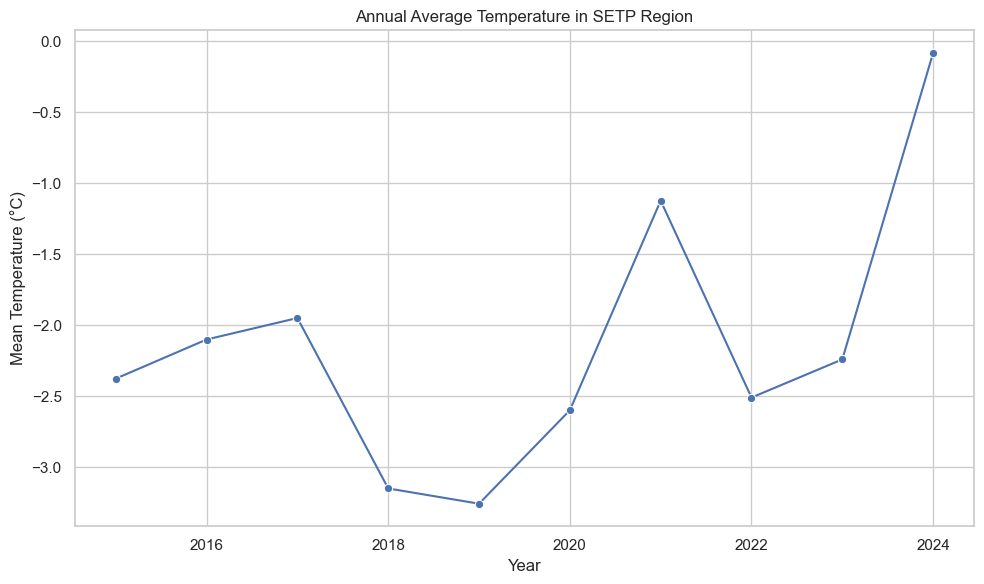

In [5]:
# 假设 date_results 和 temp_results 分别为提取到的日期和温度列表
data = pd.DataFrame({
    'Date': date_results, 
    'Mean Temperature (°C)': temp_results
})

# 提取年份信息
data['Year'] = pd.to_datetime(data['Date']).dt.year

# 计算年度均温
annual_avg_temp = data.groupby('Year')['Mean Temperature (°C)'].mean().reset_index()

# 设置绘图风格
sns.set(style="whitegrid")

# 创建折线图
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='Year', y='Mean Temperature (°C)', data=annual_avg_temp, marker='o', color='b')

# 设置标签和标题
ax.set_title('Annual Average Temperature in SETP Region')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')

plt.tight_layout()
plt.show()

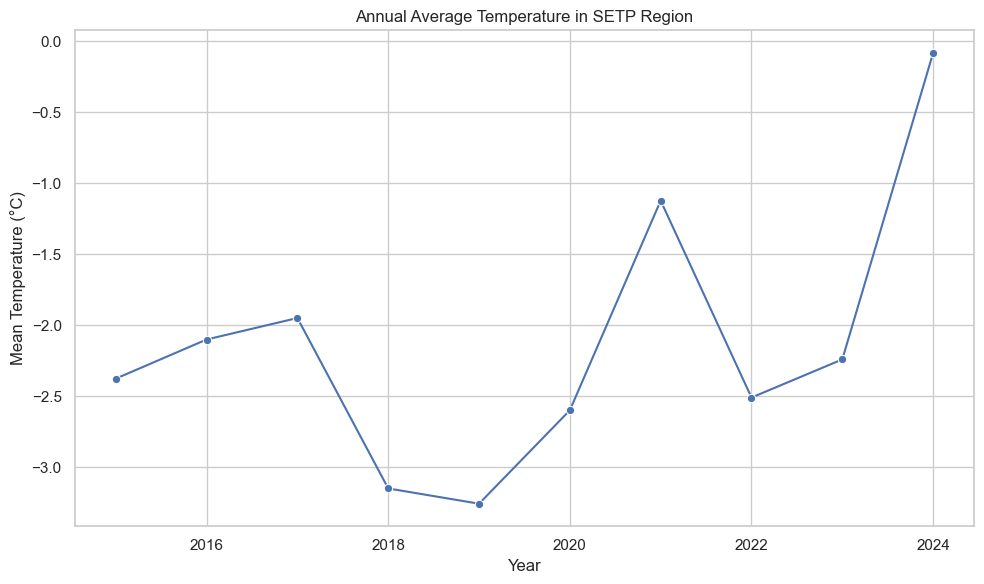

In [6]:
# 假设 date_results 和 temp_results 分别为提取到的日期和温度列表
data = pd.DataFrame({
    'Date': date_results, 
    'Mean Temperature (°C)': temp_results
})

# 提取年份信息
data['Year'] = pd.to_datetime(data['Date']).dt.year

# 计算年度均温
annual_avg_temp = data.groupby('Year')['Mean Temperature (°C)'].mean().reset_index()

# 设置绘图风格
sns.set(style="whitegrid")

# 创建折线图
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='Year', y='Mean Temperature (°C)', data=annual_avg_temp, marker='o', color='b')

# 设置标签和标题
ax.set_title('Annual Average Temperature in SETP Region')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')

plt.tight_layout()
plt.show()